In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy

# Visualize

In [2]:
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, image3, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[2].set_title(titles[2])
    axes[2].imshow(image3)
    axes[2].axis('off')
    


    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename, bbox_inches='tight')


    plt.show()

In [29]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


# ResNet 

# Regular

In [32]:
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f"
images_cw_base = "Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-Regular_integrated-False.pickle"
images_cw_rbf = "Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-Regular_integrated-True.pickle"
images_benign_base = "Benign_Datasets/CW_benign_samples_5120_test_detector-type-Regular_integrated-True.pickle"

predictions_integrated = "Predictions/Model/CW_type-adversarial_5120_test_detector-type-Regular_integrated-True.pickle"
predictions_base = "Predictions/Model/CW_type-adversarial_5120_test_detector-type-Regular_integrated-False.pickle"


predictions_benign_rbf = "Predictions/RBF/CW_type-benign_5120_test_detector-type-Regular_integrated-False_rbf.pickle"
predictions_base_rbf = "Predictions/RBF/CW_type-adversarial_5120_test_detector-type-Regular_integrated-False_rbf.pickle"
predictions_integrated_rbf = "Predictions/RBF/CW_type-adversarial_5120_test_detector-type-Regular_integrated-True_rbf.pickle"

images_cw_base = os.path.join(base_path, images_cw_base)
images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign_base = os.path.join(base_path, images_benign_base)
predictions_base_path = os.path.join(base_path, predictions_base)
predictions_integrated_path = os.path.join(base_path, predictions_integrated)

predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)

In [33]:
with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)

with open(images_benign_base, 'rb') as in_file:
    images_benign_base = pickle.load(in_file)

with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])
    pred_labels_base = np.asarray(predictions['pred_labels'])

with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])
    pred_labels_integrated = np.asarray(predictions['pred_labels'])

with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])

with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])






In [85]:
idx = 78


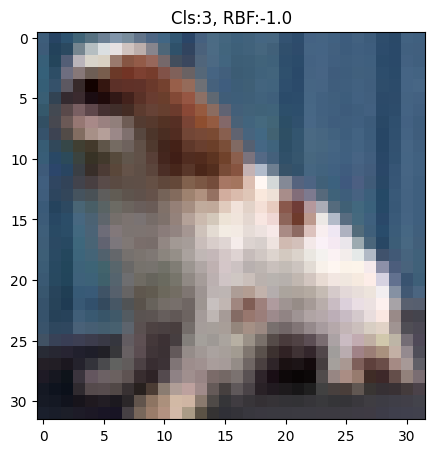

In [86]:
title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)

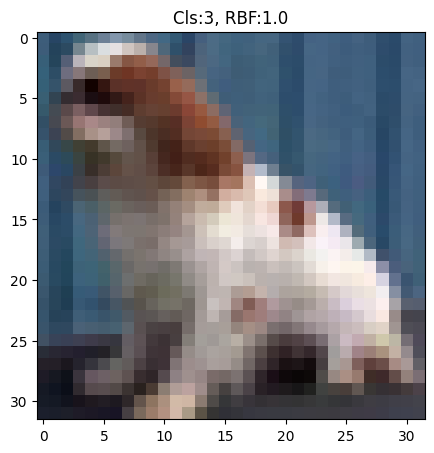

In [87]:
title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
imshow(images_cw_rbf[0][idx], title=title)

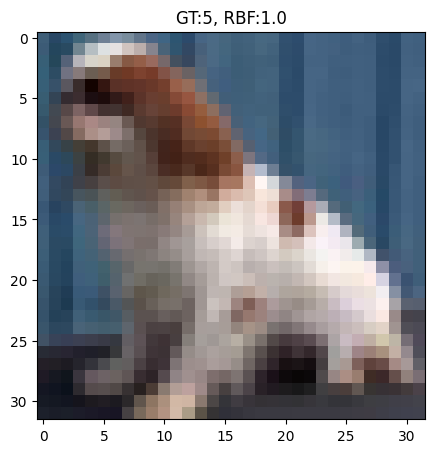

In [88]:
title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign_base[0][idx], title=title)

# Compute pixel-wise metrics


In [10]:
import torch.nn as nn

In [11]:
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [12]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW base and benign images is : ", l2_loss_base.item())

Mean per-pixel difference between CW base and benign images is :  1.1615121366048697e-05


In [13]:
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW with RBF and benign images is : ", l2_loss_rbf.item())

Mean per-pixel difference between CW with RBF and benign images is :  1.616813642613124e-05


In [14]:
MSELoss = nn.MSELoss(reduction='none')
flatten = nn.Flatten()

In [15]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign_base[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean()
print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())

Mean max pixel differene between CW base and benign is :  0.00046770437620580196


In [16]:
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign_base[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean()
print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())

Mean max pixel differene between CW RBF and benign is :  0.0005876303766854107


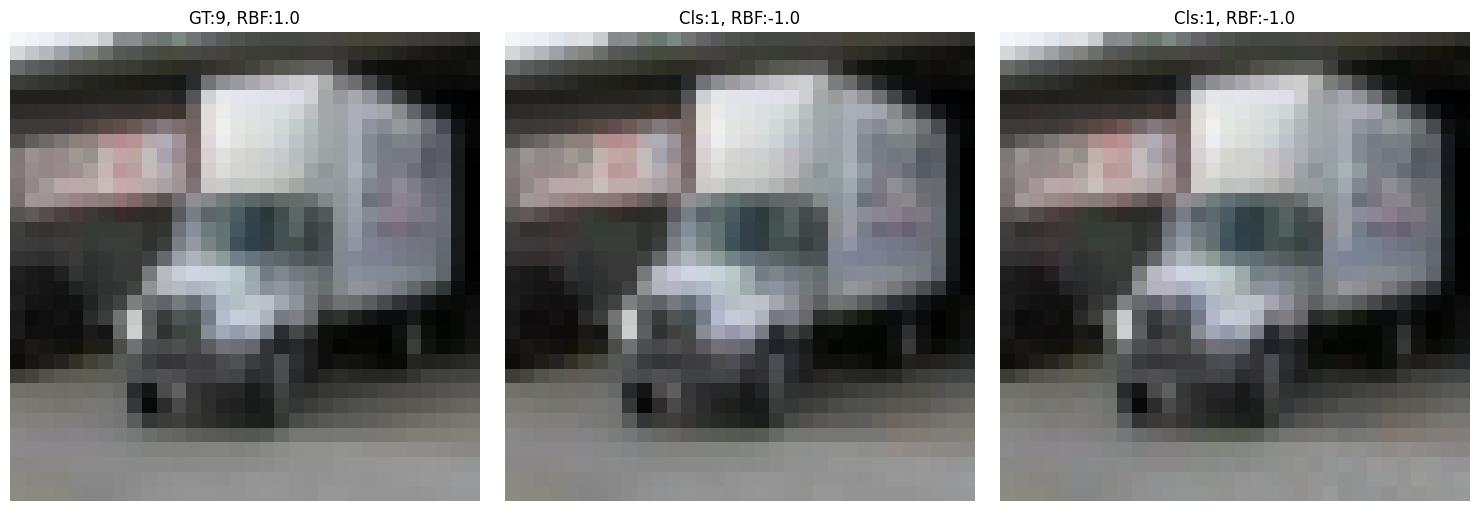

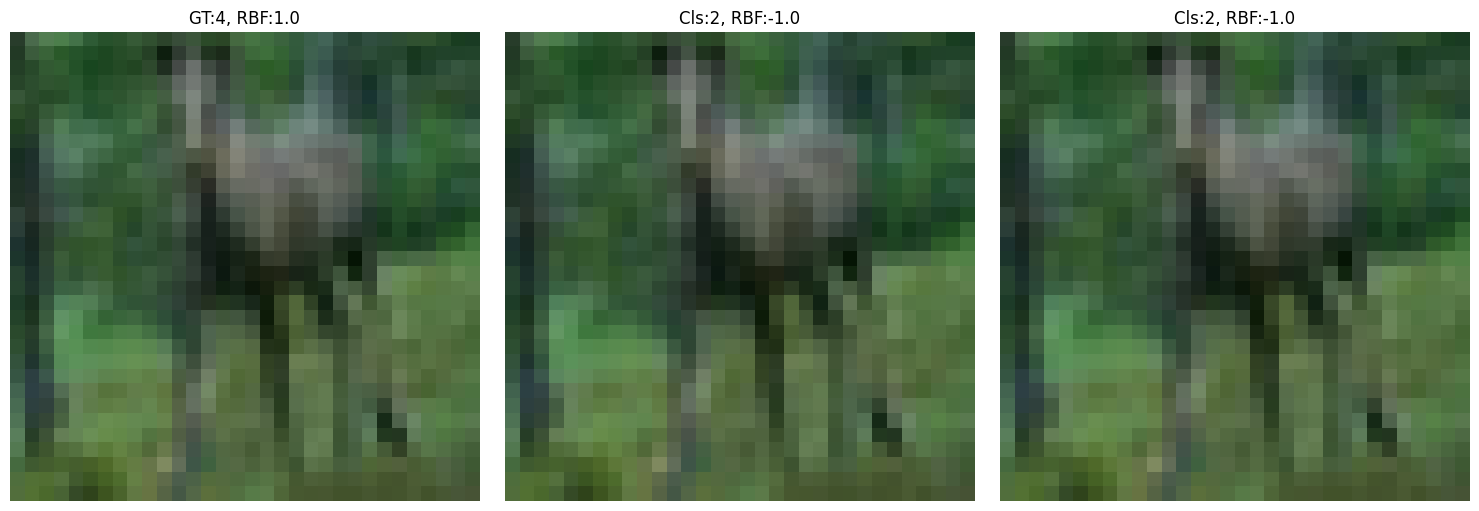

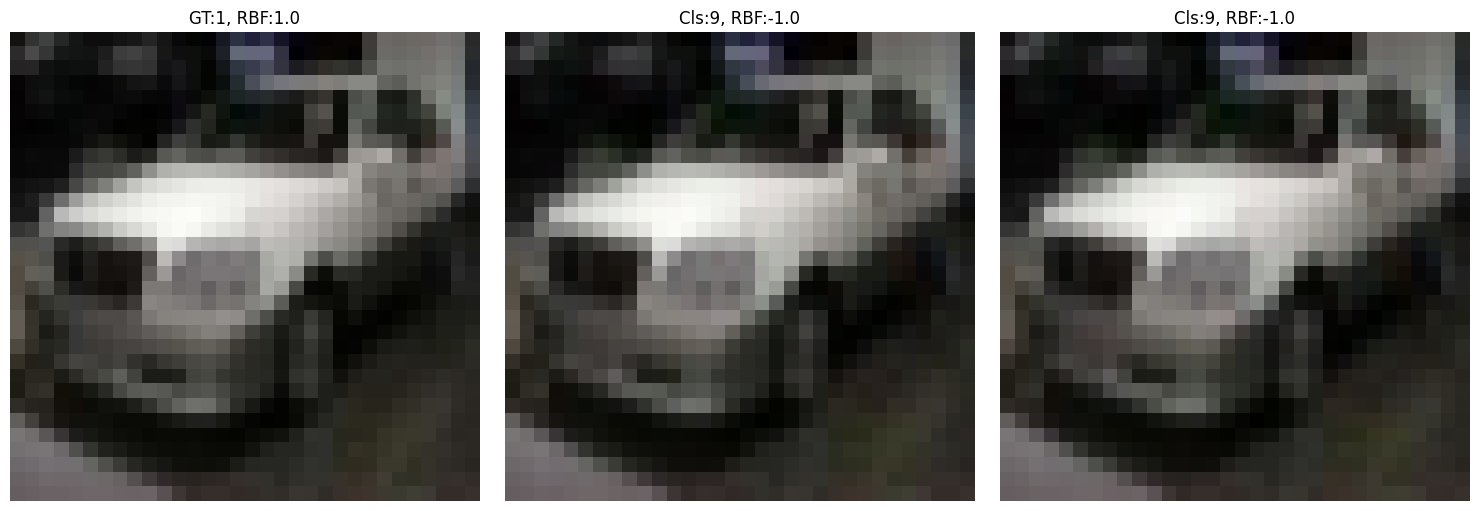

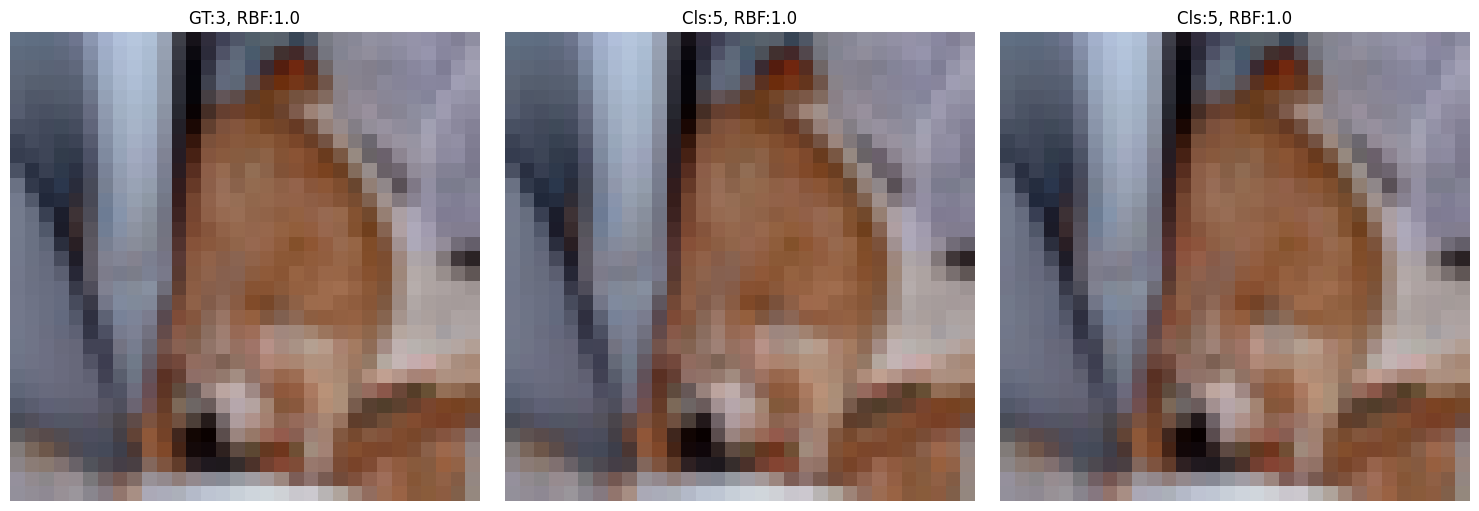

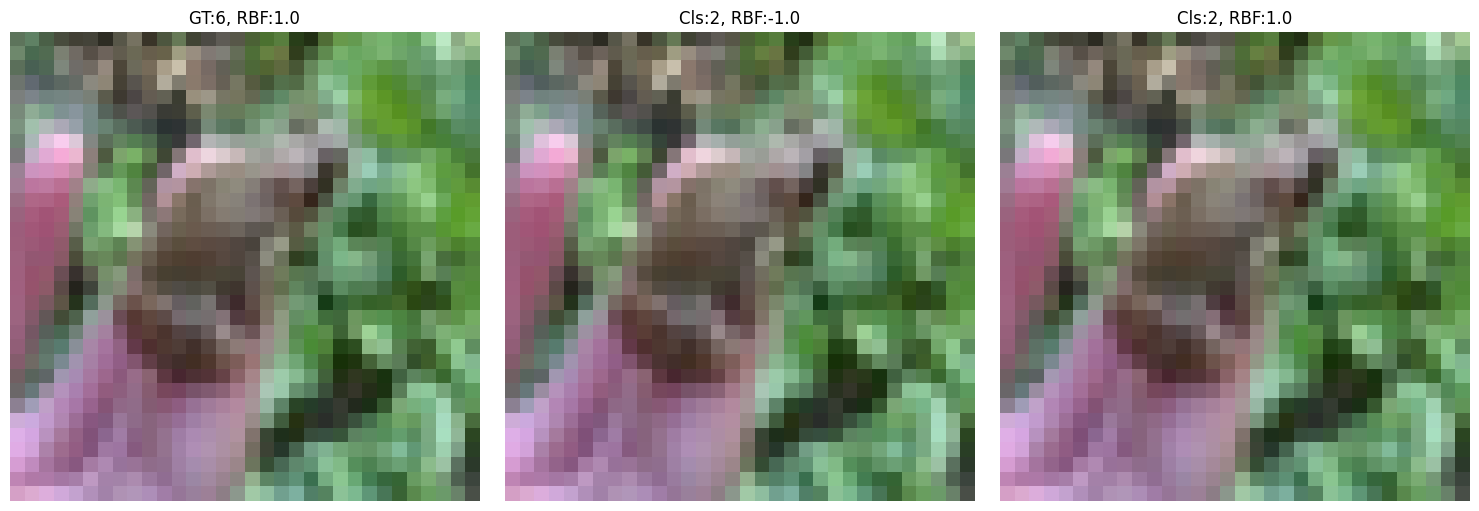

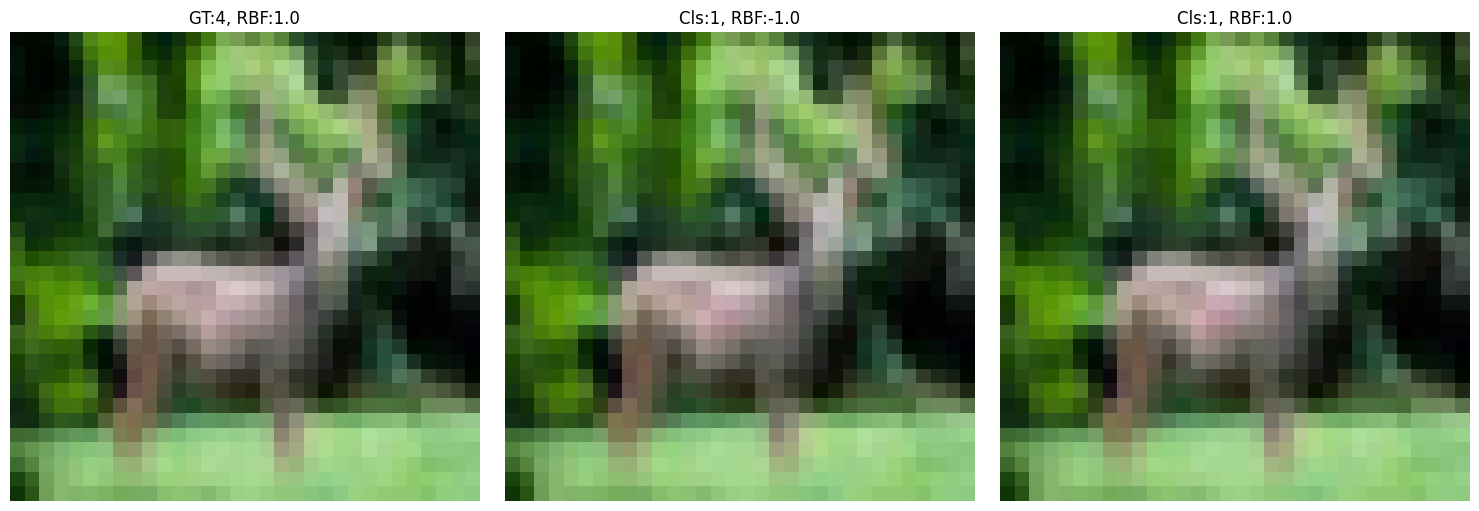

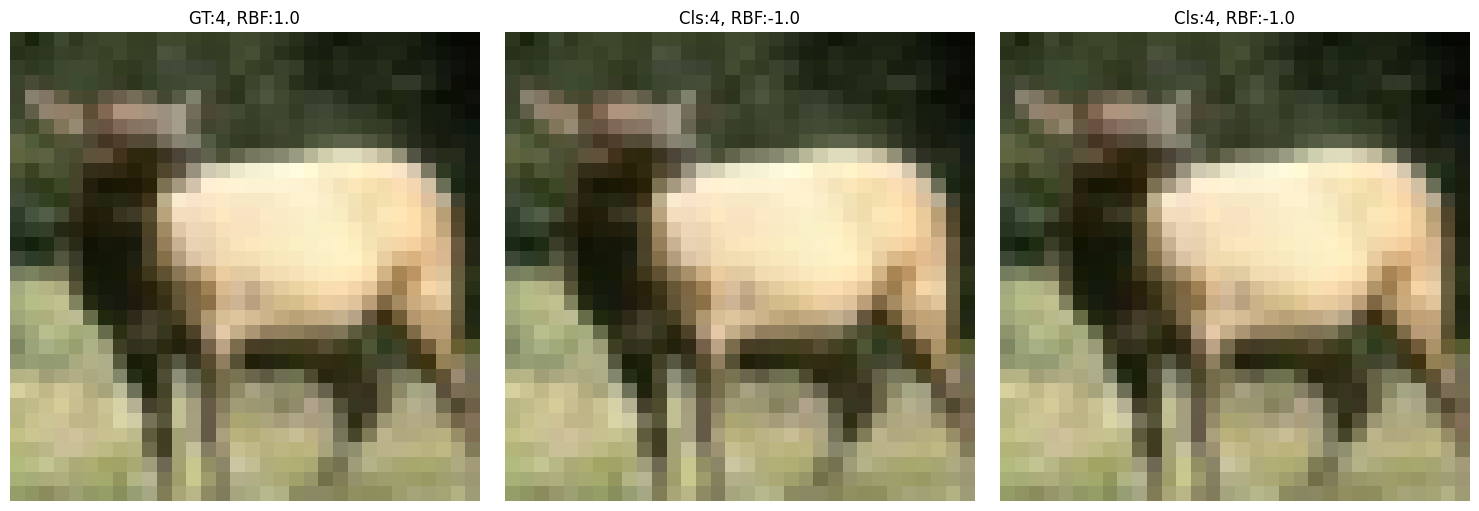

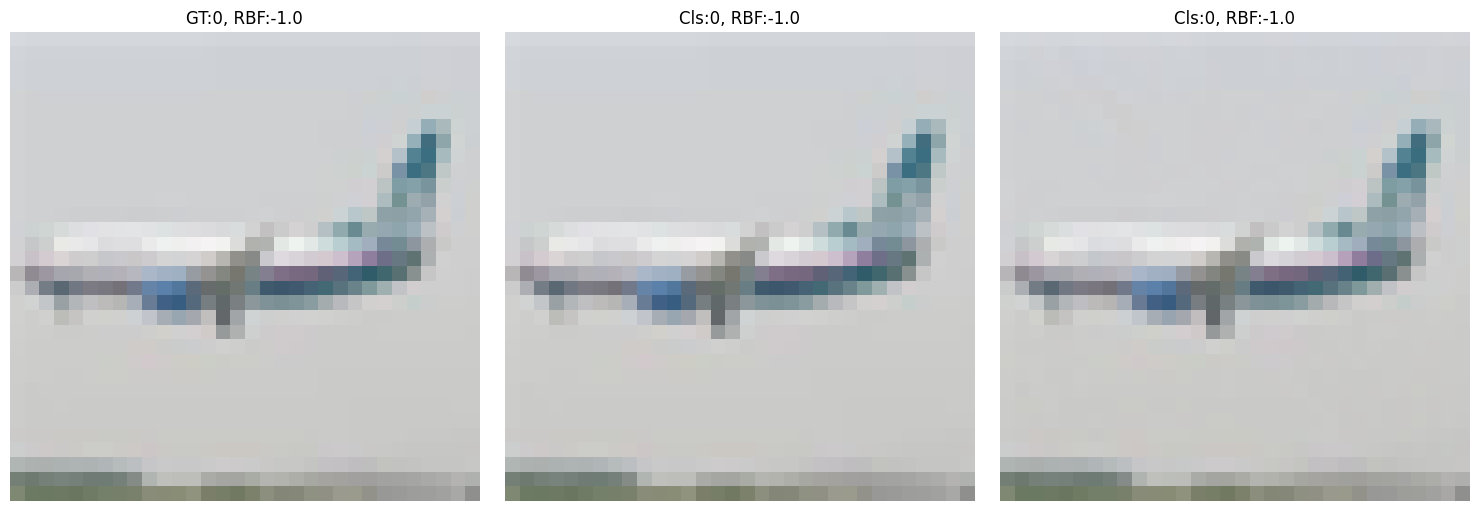

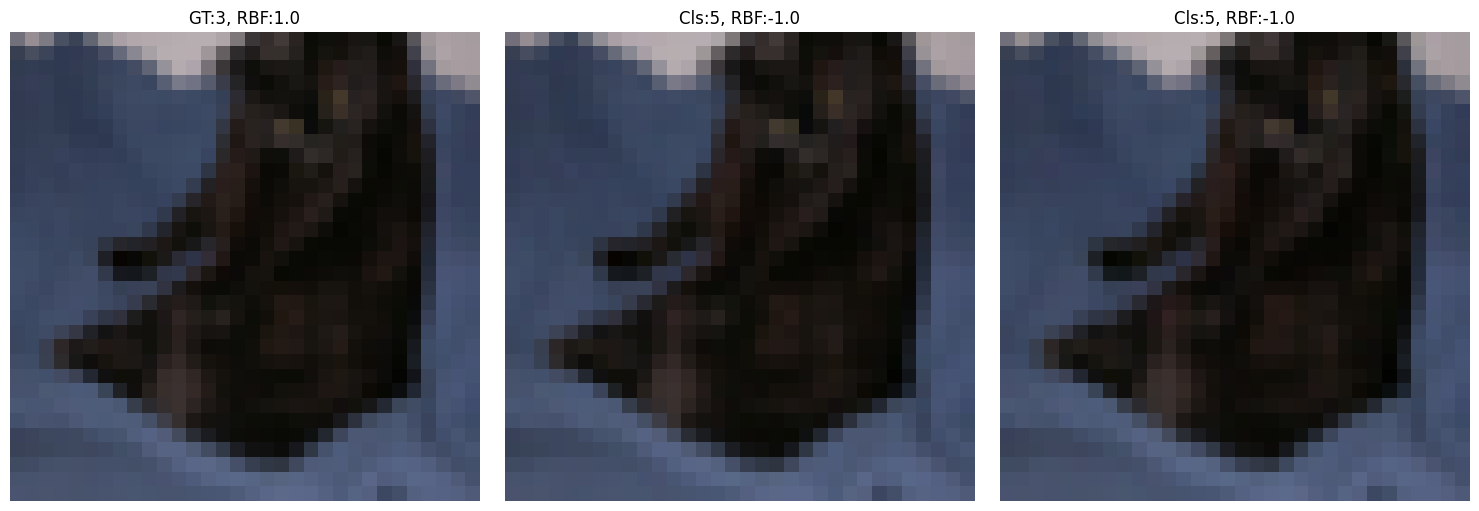

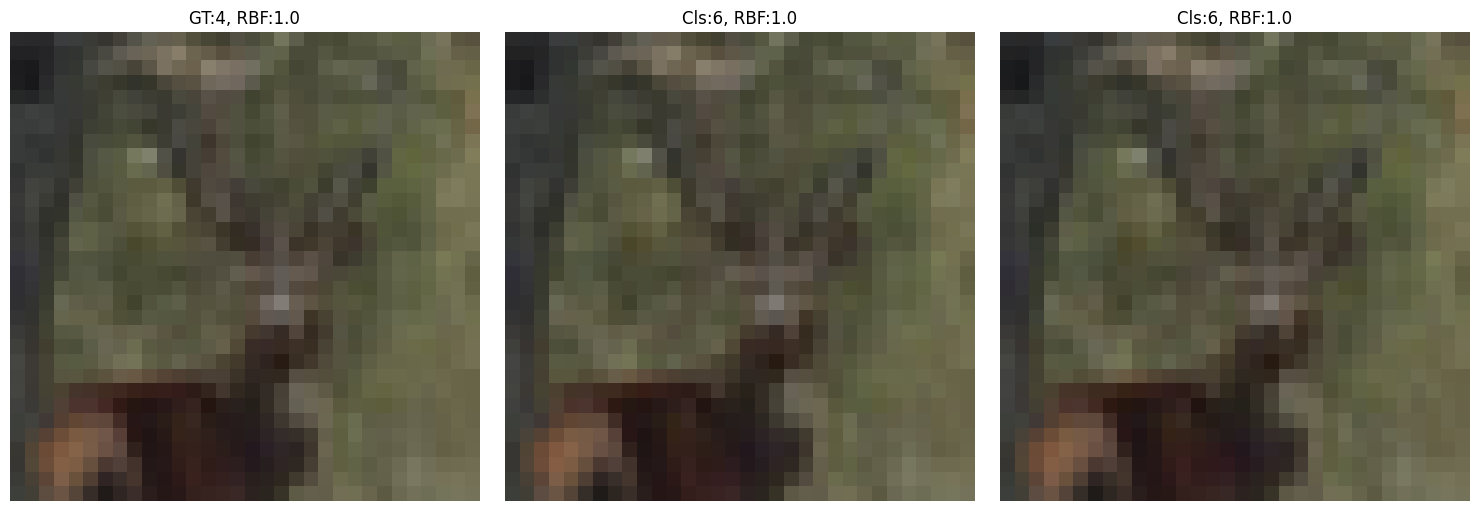

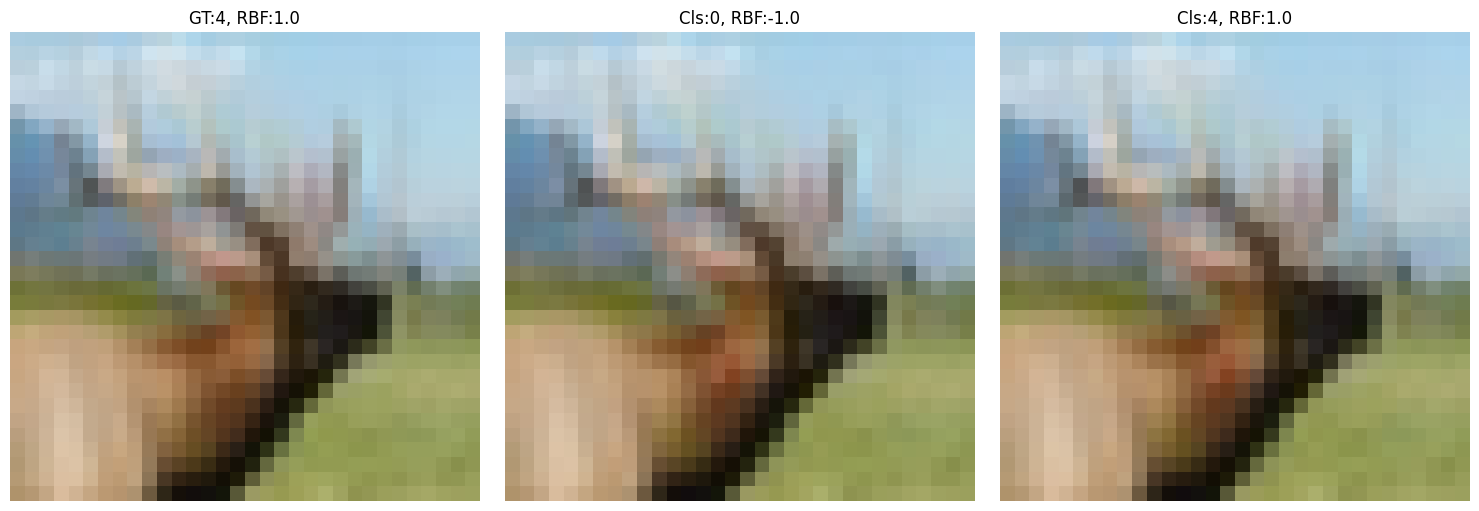

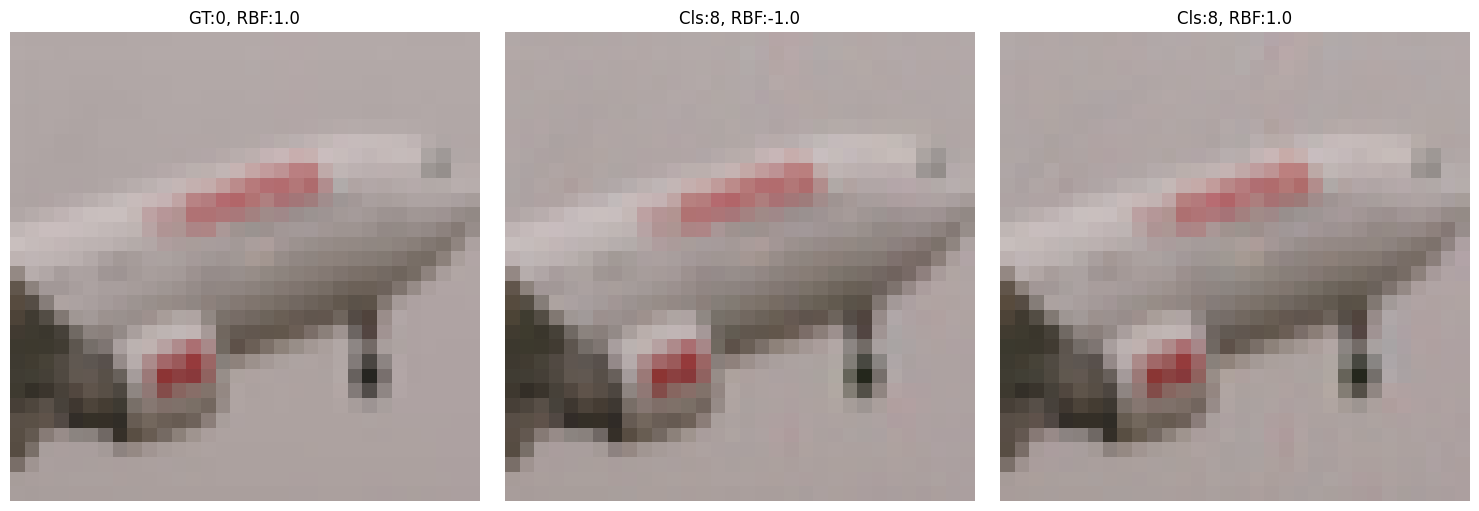

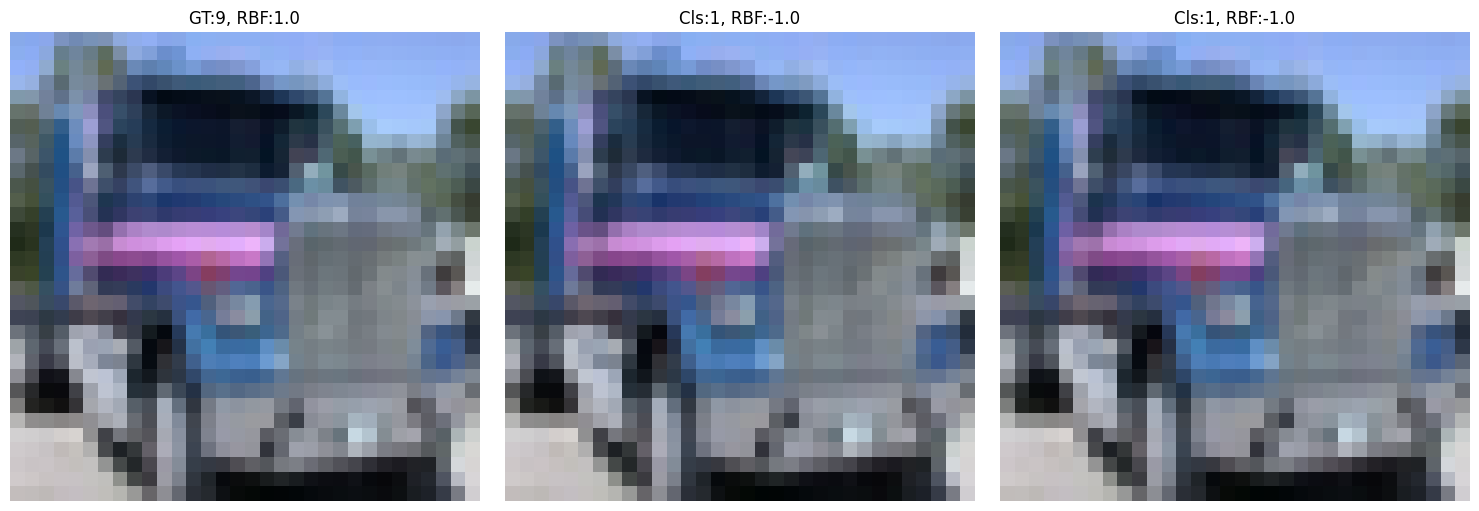

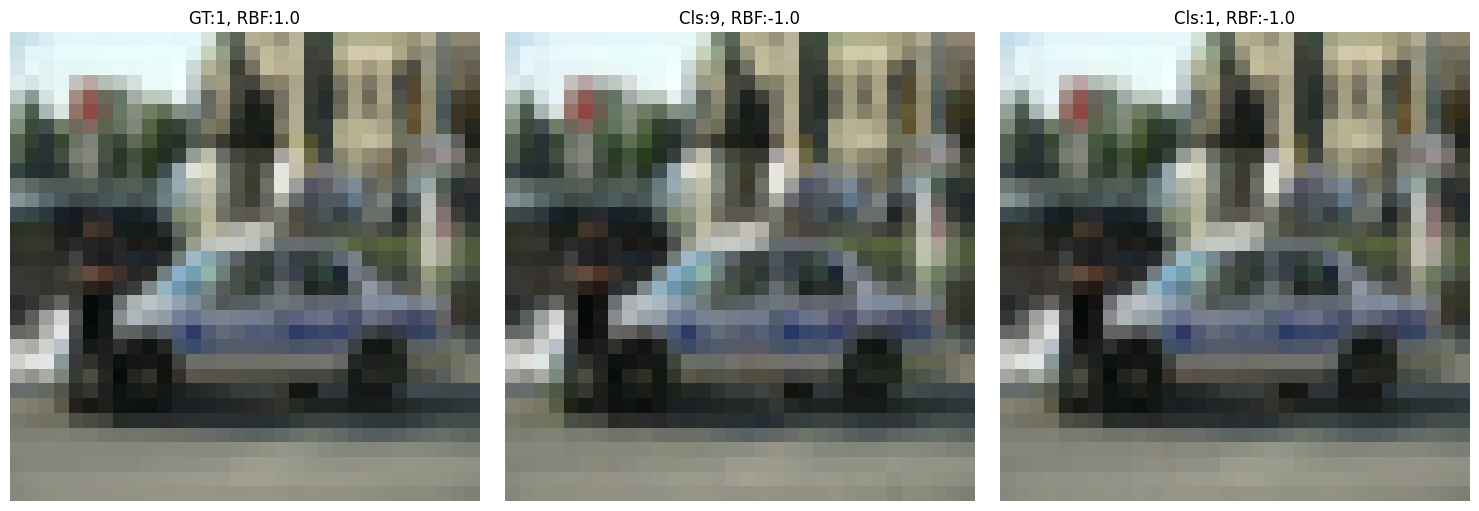

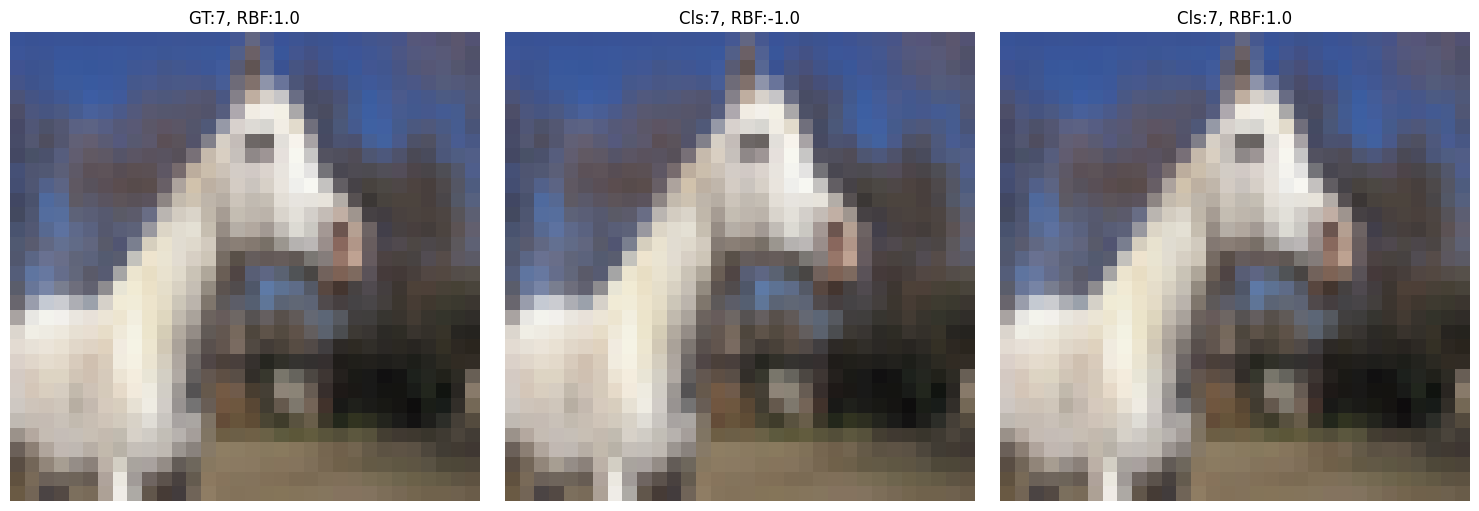

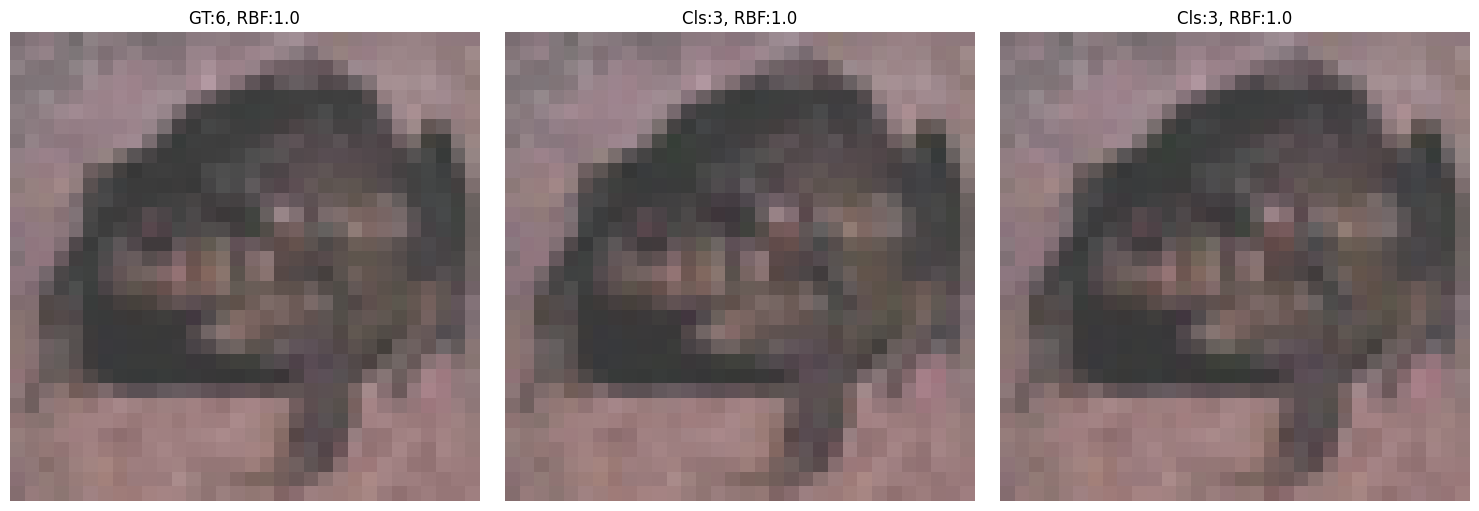

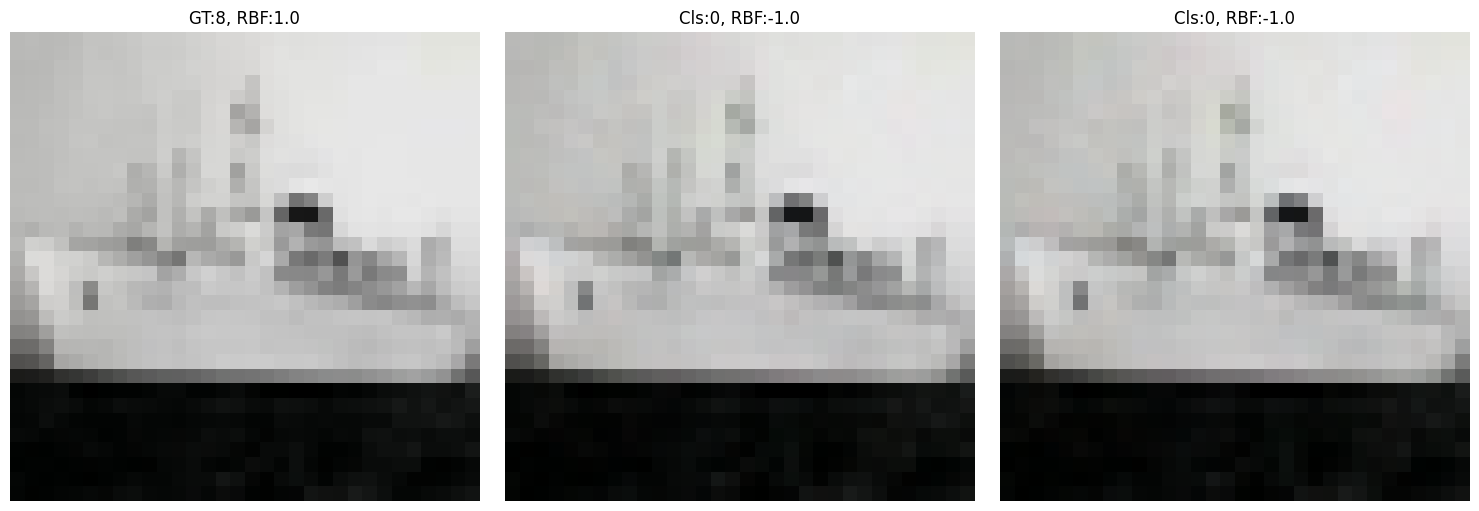

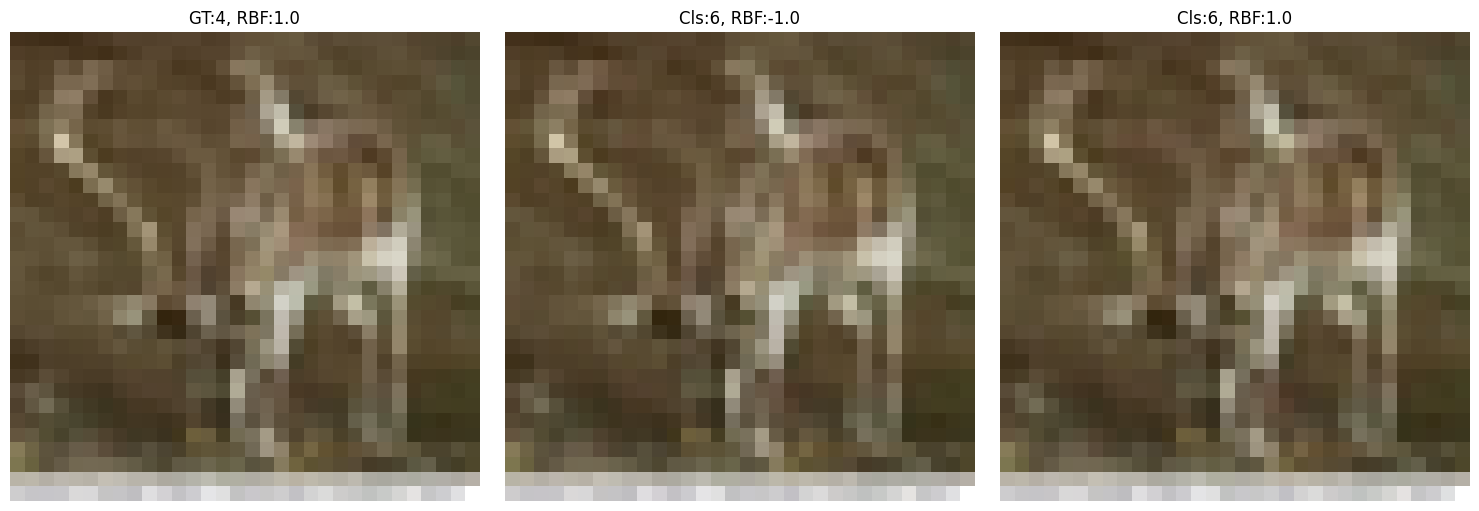

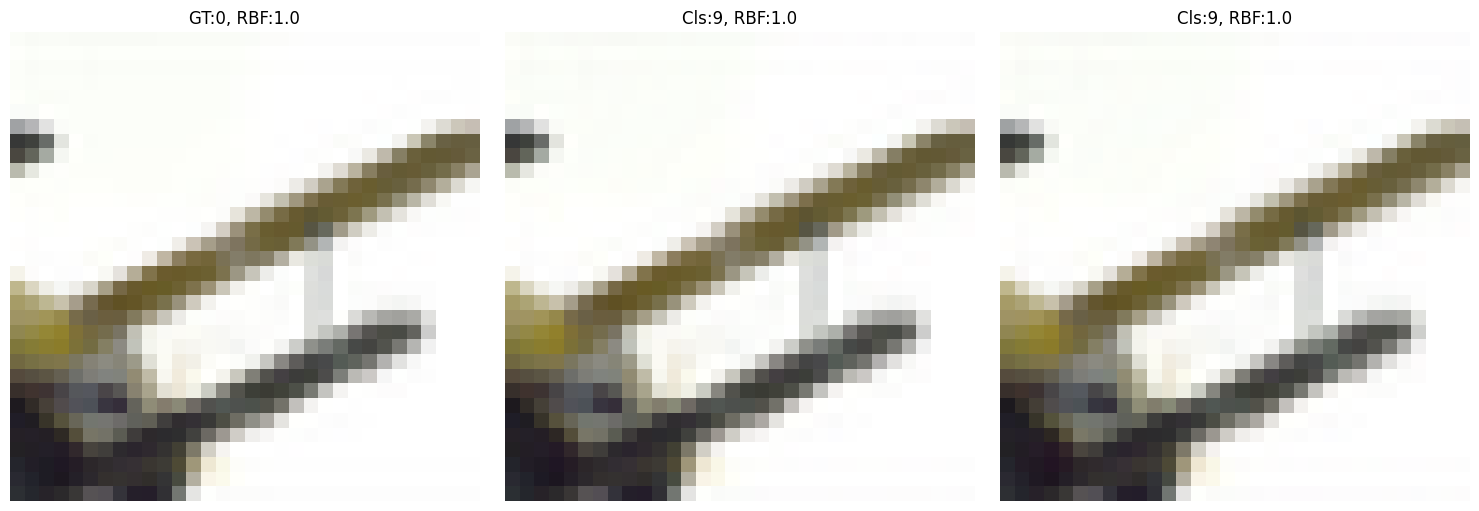

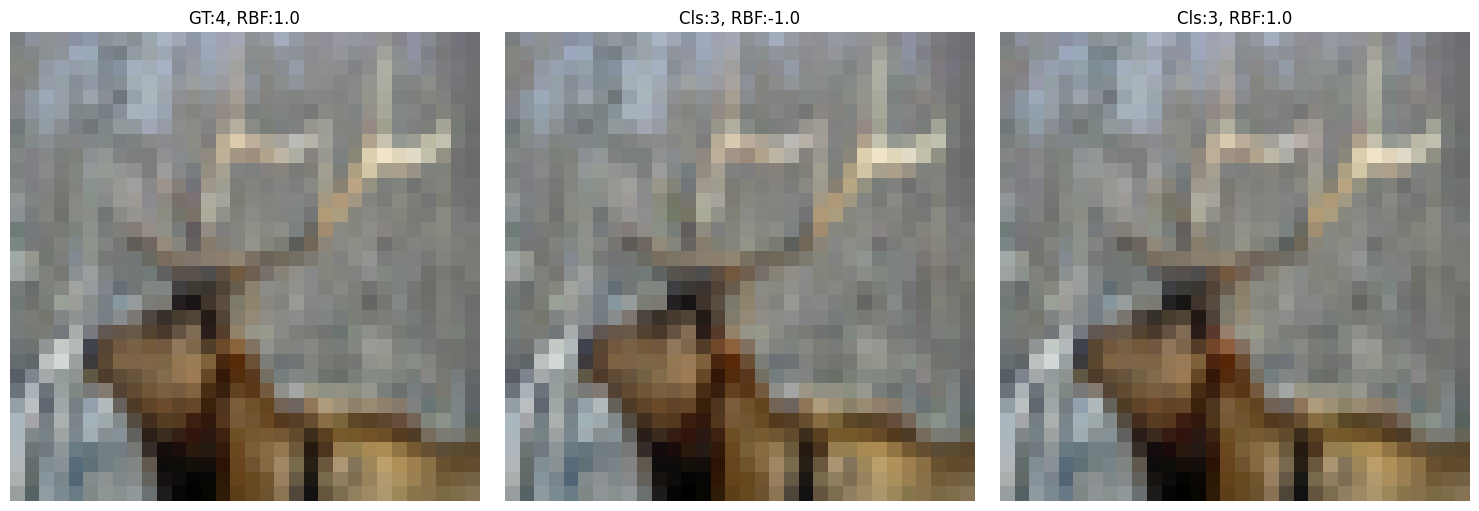

In [89]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Vis"

for idx in range(20):
    benign = images_benign_base[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)